## Импорты

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os

from PIL import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Polygon, Point, MultiPolygon
from shapely.ops import cascaded_union
import contextily as cx

from eolearn.core import EOPatch, FeatureType
import geoviews as gv

C:\Users\femt0\miniforge3\envs\eol\lib\site-packages\holoviews\operation\datashader.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Callable


## Путь к датасету

In [2]:
data_folder = 'datasets/sentinel2-l2a/64x64-10/'

## Соберём данные о произошедших утечках:

Предварительно очистим файл:

In [3]:
reestr = pd.read_excel('datasets/Reestr-ZZ-na-18.05.2021.xlsx')

In [4]:
reestr = reestr[['Вид приоритетного загрязняющего вещества',
                 'Регистрационный номер загрязненного участка в Реестре',
                 'Местоположение загрязненного участка',
                 'Административный район',
                 'Координаты загрязненного участка (в географической системе координат)',
                 'Unnamed: 12',
                 'Категория земель до загрязнения',
                 'Площадь загрязненного участка, га',
                 'Уровень загрязнения почв и земель нефтью,  нефтепродуктами, мг/кг ',
                 'Уровень содержания нефти, нефтепродуктов в донных отложениях водных объектов, мг/кг;  уровень содержания нефти, нефтепродуктов в поверхностных водах, мг/куб.дм',
                 'Дата факта последнего разлива']].dropna()

In [5]:
reestr.rename(columns={
    'Вид приоритетного загрязняющего вещества': 'pollutant_type',
    'Регистрационный номер загрязненного участка в Реестре': 'reg_num',
    'Местоположение загрязненного участка': 'location',
    'Административный район': 'adm_region',
    'Координаты загрязненного участка (в географической системе координат)': 'longitude',
    'Unnamed: 12': 'latitude',
    'Категория земель до загрязнения': 'land_category',
    'Площадь загрязненного участка, га': 'pol_area',
    'Уровень загрязнения почв и земель нефтью,  нефтепродуктами, мг/кг ': 'pol_lvl',
    'Уровень содержания нефти, нефтепродуктов в донных отложениях водных объектов, мг/кг;  уровень содержания нефти, нефтепродуктов в поверхностных водах, мг/куб.дм':
    'oil_lvl',
    'Дата факта последнего разлива': 'spill_date'
}, inplace=True)

Функции для обработки координат, находящихся в текстовом виде:

In [6]:
def preprocess(longitude):
  if type(longitude) is float:
    result = float(longitude)
  else:
    result = longitude.replace('°', ' ').replace("'", " ").replace('"', '').replace(',', '.').replace('´', '') \
                      .replace('  ', ' ').replace('ʹ', '').replace('ʹʹ', '').replace('E', '').replace('N', '') \
                      .replace('\\', '').replace('⁰', '.').replace('ʺ', '').replace('\n', '').replace('"', '') \
                      .replace('  ', ' ').replace('˚', '').replace('/', '').replace('*', '') \
                      .replace('’', '').strip(' ').split(' ')
  return result

def to_decimal(longitude):
  if type(longitude) is list:
    if len(longitude) == 3:
      degree = int(longitude[0])
      minute = int(longitude[1]) / 60
      second = float(longitude[2]) / 3600 
      result = degree + minute + second
    else:
      result = longitude[0]
  else:
    result = longitude
  return result

In [7]:
reestr['longitude'] = reestr.longitude.apply(lambda x: preprocess(x))
reestr['longitude'] = reestr.longitude.apply(lambda x: to_decimal(x))
reestr['latitude'] = reestr.latitude.apply(lambda x: preprocess(x))
reestr['latitude'] = reestr.latitude.apply(lambda x: to_decimal(x))

reestr['longitude'] = reestr['longitude'].astype('float')
reestr['latitude'] = reestr['latitude'].astype('float')

reestr.to_csv('clear.csv')
clear_data = reestr.reset_index(drop=True).drop('spill_date', axis=1)

#del reestr

In [8]:
clear_data.drop([11585, 11049, 11568], axis=0, inplace=True)

Функция для проверки координат, необходимая для создания геометрии:

In [9]:
def PointByCoords(row):
    lon = row['longitude']
    lat = row['latitude']
    if lon <= 62.5:
        lon, lat = lat, lon
    return Point(lon, lat)

In [10]:
clear_data['geometry'] = clear_data.apply(PointByCoords, axis=1)

clear_gdf = gpd.GeoDataFrame(
    clear_data, geometry=clear_data.geometry,
    crs="EPSG:4326")  #.to_crs(epsg=32637) CRS для метров

C:\Users\femt0\AppData\Roaming\Python\Python39\site-packages\pandas\core\dtypes\cast.py:121: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [11]:
#d = {'reg_num': ['ПП-2020-2'], 'geometry': [eopatch[FeatureType.BBOX].geometry]}

#gdf = gpd.GeoDataFrame(d, crs="EPSG:4326")

### Просмотр результатов на карте:

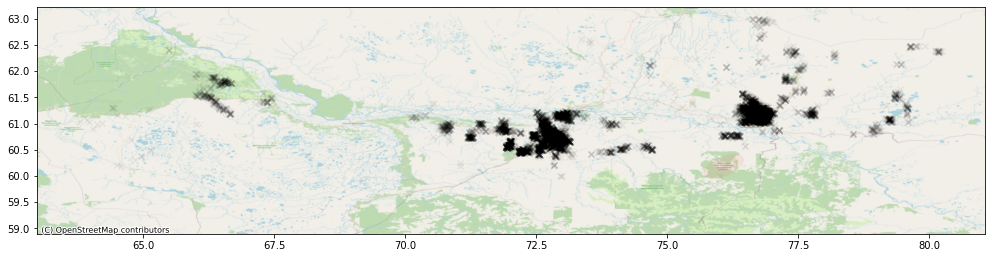

In [12]:
ax = clear_gdf.plot(figsize=(17,17),
                    color='black',
                    marker='x',
                    alpha=0.05)
cx.add_basemap(ax, crs=clear_gdf.crs, source=cx.providers.OpenStreetMap.Mapnik)

#clear_gdf.explore()

### Экспорт в файл

In [13]:
#clear_gdf.to_file('dataframe.shp')
clear_gdf.sort_values(by='pol_area', ascending=False).head(50).to_file('top50.geojson', driver='GeoJSON')

## Сопоставим имеющиеся данные и спутниковые фотографии:

Все даты, которые сможем - преобразуем в DateTime

In [14]:
test_data = reestr.reset_index(drop=True).copy()

out = test_data['spill_date'].value_counts().head(11).index.to_list()

test_data = test_data[~test_data['spill_date'].isin(out)]

test_data.loc[test_data['spill_date'] == '29.03.2017', 'spill_date'] = pd.to_datetime('29.03.2017')
test_data.loc[
    test_data["spill_date"].apply(type) == int, 'spill_date'] = pd.to_datetime(test_data[(test_data["spill_date"].apply(type) == int)]['spill_date'], format='%Y')

In [15]:
# Удалим строки
test_data = test_data[~(test_data["spill_date"].apply(type) == str)]

#Окончательно прогоним, получив даты, и выделим год и месяц
test_data['spill_date'] = pd.to_datetime(test_data['spill_date'])
test_data['spill_year'] = test_data['spill_date'].dt.year
test_data['spill_mnth'] = test_data['spill_date'].dt.month

Оставим только все данные моложе 2017 года, и с площадью разлива более 0,01 га (более 100 кв. м.)

In [16]:
good_data = test_data[
    (test_data['spill_year'] >= 2017) & (test_data['pol_area'] >= 0.01)].drop(columns='spill_date')
#Какие-то битые файлы начинающиеся с РН-ТОМСКН
good_data = good_data[~good_data['reg_num'].str.contains("РН-ТОМСКН")].reset_index(drop=True)

### Сопоставим с фото

In [17]:
reg_num_list = good_data['reg_num'].unique().tolist()

In [18]:
good_data['spill_year'].unique().tolist()

[2019, 2018, 2020, 2017]

In [19]:
good_data[good_data['spill_year'] == 2018]['reg_num'].to_list()

dict_by_year = {}

for i in good_data['spill_year'].unique().tolist():
    dict_by_year[f'{i}'] = good_data[good_data['spill_year'] == i]['reg_num'].to_list()

Добавим необходимый каталог (соответствующий как по дате, так и по участку) в таблицу для дальнейшей работы:

In [20]:
years_folders = [yf for yf in os.listdir(data_folder)]
result_dict = {}

#Включаем индусскую музыку:
for year in dict_by_year.keys():
    folders = [f for f in os.listdir(data_folder + year)]
    for each in folders:
        reg_nums = [n for n in os.listdir(data_folder + year + '/' + each) if n in dict_by_year[f'{year}']]
        for reg in reg_nums:
            good_data.loc[good_data['reg_num'] == reg, 'folder'] = each

Фукнция, которая по строке вызывает изображение:

In [21]:
def load_patch(row):
    i_ = row.name
    path_to = data_folder + str(row['spill_year']) + '/' + row['folder'] + '/' + row['reg_num']
    print('Путь до данных:', path_to)
    print(row['spill_mnth'])
    print(row['pol_area'])
    
    eopatch = EOPatch.load(path_to)
    
    avaible_mnths = set()
    need_mnth = row['spill_mnth']

    for i in range(len(eopatch[FeatureType.TIMESTAMP])):
        avaible_mnths.add(eopatch[FeatureType.TIMESTAMP][i].month)

    while True:
        if need_mnth not in avaible_mnths:
            need_mnth += 1
        else:
            break

    for i in range(len(eopatch[FeatureType.TIMESTAMP])):
        if eopatch[FeatureType.TIMESTAMP][i].month == need_mnth:
            plt.imshow(eopatch[FeatureType.DATA]['L2A'][i,:,:,7]) #NIR band
            #plt.imshow(eopatch[FeatureType.DATA]['L2A'][ш,:,:,1:4]) #RGB band
            plt.title(str(eopatch[FeatureType.TIMESTAMP][i]))
            plt.tight_layout()
            
    return eopatch[FeatureType.DATA]['L2A'][i,:,:,7]

Проверим функцию:

Путь до данных: datasets/sentinel2-l2a/64x64-10/2018/2018-01/ЛУК-ЛНГ-2018-8
10
0.2


array([[5.296, 5.692, 6.28 , ..., 7.372, 7.428, 5.444],
       [5.424, 6.128, 5.928, ..., 6.992, 7.124, 6.412],
       [5.18 , 6.032, 5.956, ..., 6.816, 7.176, 7.256],
       ...,
       [4.312, 3.874, 3.928, ..., 3.972, 3.98 , 5.028],
       [3.92 , 3.52 , 3.404, ..., 5.104, 4.732, 4.956],
       [3.696, 3.426, 3.296, ..., 4.808, 4.064, 4.476]], dtype=float32)

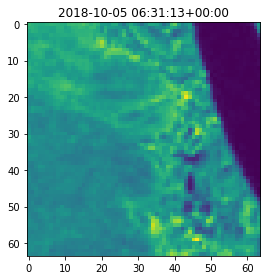

In [22]:
load_patch(good_data.iloc[10])

- CLD: **Raster mask**. values range from 0 for high confidence clear sky to 100 for high confidence cloudy
- CLM: **cloud mask**    CLM: 0 (no clouds), 1 (clouds), 255 (no data)
- CLP: **cloud probablity** 0–255 (divide by 255 to get to the [0-1] range)
- IS_DATA: 
- SCL: **scene classification layer**. The meaning of the values is indicated in the Category Names of the band
- SNW: Raster mask values range from 0 for high confidence NO snow/ice to 100 for high confidence snow/ice

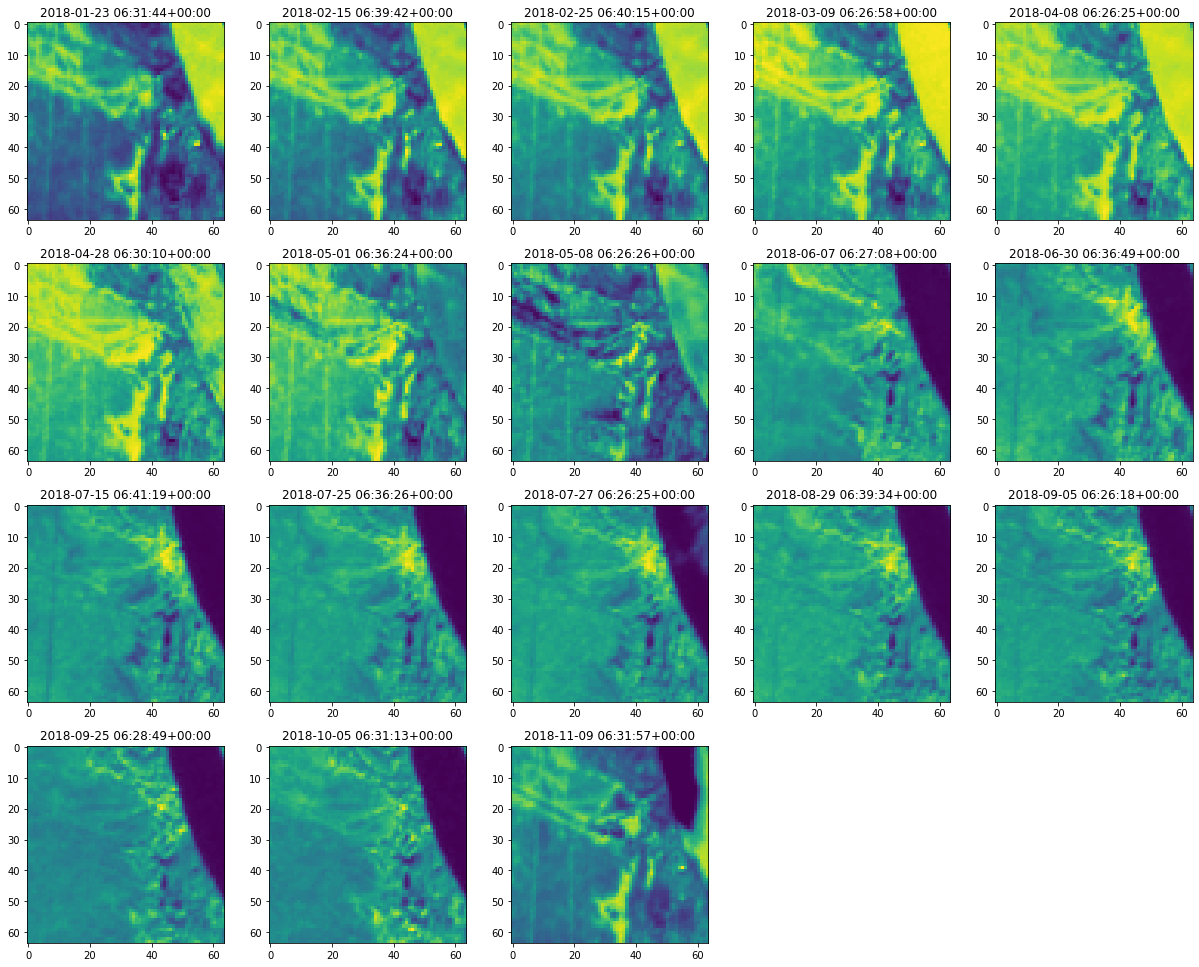

In [23]:
eopatch = EOPatch.load('datasets/sentinel2-l2a/64x64-10/2018/2018-01/ЛУК-ЛНГ-2018-8')

fig = plt.figure(figsize=(17,20))
for c in range(len(eopatch[FeatureType.TIMESTAMP])):
    ax = fig.add_subplot(6, 5, c+1, title=str(eopatch[FeatureType.TIMESTAMP][c]))
    ax.imshow(eopatch[FeatureType.DATA]['L2A'][c,:,:,7]) #cmap=plt.get_cmap('Greys')) #NIR
    #ax.imshow(eopatch[FeatureType.DATA]['L2A'][c,:,:,1:4])
    plt.tight_layout()